# Recovery of gold from ore

Prepare a prototype of a machine learning model for "Digits". The company develops solutions for the efficient operation of industrial enterprises.

The model should predict the gold recovery coefficient from gold-bearing ore. Use data with parameters of extraction and purification.

The model will help optimize production to avoid launching a facility with unprofitable characteristics.

We need to:

1. Prepare the data;
2. Conduct exploratory data analysis;
3. Build and train the model.

# Research process:

- Open the data files with the following paths: 'gold_industry_train.csv', 'gold_industry_test.csv', 'gold_industry_full.csv'. The data is indexed by the date and time of information acquisition (feature: date). Parameters obtained at close times are often similar. The dataset 'gold_industry_full.csv' contains both training and test sets.
Conduct analysis and data preprocessing if necessary.
Verify the formula for calculating the enrichment efficiency.
Analyze features not available in the test set.
- Preprocess the data.
    - Examine the changes in the concentration of elements at each stage.
    - Analyze the distribution of particle sizes in the training and test sets.
    - Investigate total concentrations.
    - Build a prediction model.
    - Write a function to calculate the final sMAPE.
    - Train and test several models.
    - Choose the best model and assess its quality on the test set.
    - The data should adhere to the following parameters:

- Technological process:
    - Rougher feed — initial raw material.
    - Rougher additions (or reagent additions) — flotation reagents: Xanthate, Sulphate, Depressant.
    - Xanthate — xanthate (promoter or flotation activator).
    - Sulphate — sulfate (sodium sulfide in this production).
    - Depressant — depressant (sodium silicate).
    - Rougher process — flotation.
    - Rougher tails — tailings.
    - Float banks — flotation unit.
    - Cleaner process — cleaning.
    - Rougher Au — rough gold concentrate.
    - Final Au — final gold concentrate.
- Stage parameters:
    - air amount — air volume.
    - fluid levels — liquid level.
    - feed size — feed particle size.
    - feed rate — feed rate.
- Feature names should be in the format:
    - [stage].[parameter_type].[parameter_name]
    - Example: rougher.input.feed_ag
- Possible values for the [stage] block:
    - rougher — flotation.
    - primary_cleaner — primary cleaning.
    - secondary_cleaner — secondary cleaning.
    - final — final characteristics.
- Possible values for the [parameter_type] block:
    - input — raw material parameters.
    - output — product parameters.
    - state — parameters characterizing the current stage state.
    - calculation — calculated characteristics.

## Data preparation

Import all the necessary libraries for the investigation.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV

Загрузим файлы и сохраним их в переменные.

In [2]:
pth1_ar = ['/Users/daniyardjumaliev/Jupyter/Projects/datasets/gold_industry_train.csv', '/Users/daniyardjumaliev/Jupyter/Projects/datasets/gold_industry_test.csv', '/Users/daniyardjumaliev/Jupyter/Projects/datasets/gold_industry_full.csv']
pth2_ar = ['backup_path1.csv', 'backup_path2.csv', 'backup_path3.csv']
gold_train = None
gold_test = None
gold_full = None

for pth1, pth2 in zip(pth1_ar, pth2_ar):
    if os.path.exists(pth1):
        query_1 = pd.read_csv(pth1)
        if 'train' in pth1:
            gold_train = query_1
            print('gold_train successfully loaded and saved from the first path!')
        elif 'test' in pth1:
            gold_test = query_1
            print('gold_test successfully loaded and saved from the first path!')
        elif 'full' in pth1:
            gold_full = query_1
            print('gold_full successfully loaded and saved from the first path!')
    elif os.path.exists(pth2):
        query_2 = pd.read_csv(pth2)
        if 'train' in pth2:
            gold_train = query_2
            print('gold_train successfully loaded and saved from the second path!')
        elif 'test' in pth2:
            gold_test = query_2
            print('gold_test successfully loaded and saved from the second path!')
        elif 'full' in pth2:
            gold_full = query_2
            print('gold_full successfully loaded and saved from the second path!')
    else:
        print(f'Warning: File not found in both paths for {pth1}')

if gold_train is None or gold_test is None or gold_full is None:
    print('Warning: Some files are missing or unavailable.')
else:
    print('Files loaded successfully.')

gold_train successfully loaded and saved from the first path!
gold_test successfully loaded and saved from the first path!
gold_full successfully loaded and saved from the first path!
Files loaded successfully.


Currently, we have only one source from which we take files for investigation. If alternative paths for locating files appear in the future, they can be added to the second array to avoid errors during the data loading stage.

Let's check for missing values and assess the data quality in the training set.

In [3]:
display('---------Train Sample-----------')
display(gold_train)
display(gold_train.describe())
display(gold_train.info())
display(f'Duplicates in the training set: {gold_train.duplicated().sum()}')
display(f'Missing values in the training set:')
display(gold_train.isna().sum())

'---------Train Sample-----------'

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2,2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
3,2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
4,2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14574,2017-12-09 09:59:59,4.599524,5.822083,4.255546,37.480479,559.895089,85.247019,6.775864,9.005425,1200.454685,...,0.000000,47.765393,2.925574,10.855586,7.053796,64.054699,1.761994,8.578502,3.365823,10.603464
14575,2017-12-09 10:59:59,4.658125,5.844800,4.241564,37.395565,561.464855,83.860651,6.770561,9.000889,1200.958146,...,0.000000,46.956275,3.076566,11.542302,6.929418,68.643324,1.567363,8.792890,3.120351,10.184715
14576,2017-12-09 11:59:59,5.335862,6.091855,4.617558,37.369774,560.889077,85.718304,7.762770,9.158609,1199.245914,...,0.000000,46.713954,3.224920,11.356233,6.803482,73.755150,1.529220,8.769645,3.141541,10.403181
14577,2017-12-09 12:59:59,4.838619,6.121323,4.144989,38.591551,559.031805,119.499241,7.356687,9.304952,1196.569267,...,0.000000,46.866780,3.195978,11.349355,6.862249,69.049291,1.612542,8.897321,3.130493,10.549470


,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
count,14579.000000,14579.000000,14507.000000,14502.000000,14572.000000,14478.000000,14548.000000,14572.000000,14579.000000,14579.000000,...,13659.000000,14579.000000,14578.000000,14578.000000,14387.000000,14579.000000,14579.000000,14578.000000,14504.000000,14574.000000
mean,8.352941,8.877460,3.604221,36.561420,474.332784,58.922712,12.427399,5.994854,1104.208278,-379.367166,...,7.111347,43.979499,5.192145,9.923809,9.566676,66.759066,3.087939,9.731972,2.719985,10.612745
std,1.934376,1.922536,1.056063,5.209823,108.503552,22.407410,3.428939,1.152873,162.235606,94.652311,...,3.909951,5.471437,1.388014,1.706976,2.805654,10.619709,0.915187,2.358143,0.958929,2.871075
min,0.010000,0.010000,0.010000,0.010000,0.002986,0.049194,0.001083,0.000568,-0.042069,-657.949759,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.932996,7.341922,2.880490,34.093951,411.048483,47.278490,10.002832,5.304167,999.644856,-499.861797,...,3.784897,43.345906,4.283347,9.103183,7.860030,63.114596,2.505287,8.088928,2.036512,9.013412
50%,8.225284,8.715859,3.532399,37.097511,498.187968,54.361187,12.003320,6.003053,1000.982624,-300.314199,...,7.629968,44.975014,5.118647,10.046455,9.301970,67.962788,3.029238,9.818512,2.774847,10.670515
75%,9.832210,10.255843,4.257282,39.899799,549.586552,64.464926,14.929903,6.796632,1292.663971,-299.989315,...,10.367050,46.275153,5.925380,10.981203,11.001573,72.598187,3.614098,11.169187,3.353845,12.130827
max,13.731330,14.596026,7.052325,53.475325,717.508837,484.967466,36.118275,9.703448,1512.299531,-273.776101,...,26.000772,52.756638,16.001945,16.705297,19.423912,100.000000,8.245022,19.552149,5.804178,22.317730


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14579 entries, 0 to 14578
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14579 non-null  object 
 1   rougher.input.feed_au                               14579 non-null  float64
 2   rougher.input.feed_ag                               14579 non-null  float64
 3   rougher.input.feed_pb                               14507 non-null  float64
 4   rougher.input.feed_sol                              14502 non-null  float64
 5   rougher.input.feed_rate                             14572 non-null  float64
 6   rougher.input.feed_size                             14478 non-null  float64
 7   rougher.input.floatbank10_sulfate                   14548 non-null  float64
 8   rougher.input.floatbank10_xanthate                  14572 non-null  float64


None

'Duplicates in the training set: 0'

'Missing values in the training set:'

date                       0
rougher.input.feed_au      0
rougher.input.feed_ag      0
rougher.input.feed_pb     72
rougher.input.feed_sol    77
                          ..
final.output.recovery      0
final.output.tail_au       0
final.output.tail_ag       1
final.output.tail_pb      75
final.output.tail_sol      5
Length: 87, dtype: int64

In [4]:
display('---------Test Sample-----------')
display(gold_test)
display(gold_test.describe())
display(gold_test.info())
display(f'Duplicates in the test set: {gold_test.duplicated().sum()}')
display(f'Missing values in the test set:')
display(gold_test.isna().sum())

'---------Test Sample-----------'

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2017-12-09 14:59:59,4.365491,6.158718,3.875727,39.135119,555.820208,94.544358,6.146982,9.308612,1196.238112,...,23.018622,-500.492702,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575
1,2017-12-09 15:59:59,4.362781,6.048130,3.902537,39.713906,544.731687,123.742430,6.210119,9.297709,1201.904177,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471
2,2017-12-09 16:59:59,5.081681,6.082745,4.564078,37.208683,558.155110,82.610855,7.363824,9.003562,1200.826926,...,22.993827,-501.559663,20.029144,-500.000662,18.012723,-500.024764,13.016445,-500.058432,19.973767,-501.394155
3,2017-12-09 17:59:59,5.145949,6.084374,4.768124,36.808874,539.713765,77.984784,6.927072,8.955597,1199.292489,...,23.032807,-501.287889,19.977466,-500.159903,17.980463,-500.504602,12.949071,-500.009937,20.010332,-508.337973
4,2017-12-09 18:59:59,5.735249,6.165220,4.512346,37.810642,558.713584,86.434874,7.823471,7.490356,1198.005449,...,23.001911,-499.947838,20.023735,-499.713680,17.990955,-500.334769,13.007523,-499.968459,19.995999,-499.788805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4855,2018-08-18 06:59:59,6.620245,5.992592,2.589242,39.934641,578.654582,63.473450,14.688804,6.898599,999.688257,...,14.003057,-503.152258,12.016724,-501.136446,10.041864,-499.338844,8.007022,-500.279583,14.001271,-602.072365
4856,2018-08-18 07:59:59,6.741324,6.158617,2.647185,40.176307,571.622005,62.815291,14.892720,6.903204,1000.479783,...,14.031220,-503.471307,11.966426,-500.656842,10.051620,-498.318772,8.018091,-499.696138,13.958937,-599.213013
4857,2018-08-18 08:59:59,6.627458,6.015149,2.466127,39.841423,563.733146,61.287347,13.723692,6.700148,1000.014718,...,13.996317,-502.995300,11.980055,-500.607751,9.964501,-499.261719,8.065048,-499.492395,13.997801,-600.621416
4858,2018-08-18 09:59:59,6.702243,6.097592,2.278955,37.728375,549.812490,59.637037,13.746510,6.706417,999.635748,...,13.983963,-503.675714,11.928745,-500.583183,9.970359,-498.822343,8.016377,-499.013145,14.000032,-600.024741


,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,4860.000000,4860.000000,4832.000000,4838.000000,4856.000000,4816.000000,4857.000000,4859.000000,4859.000000,4859.000000,...,4.859000e+03,4859.000000,4.859000e+03,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000
mean,8.005584,8.547348,3.579662,37.095864,490.285103,59.113400,12.055735,6.101308,1108.635895,-368.340127,...,1.985770e+01,-488.665140,1.557025e+01,-464.176507,16.594103,-490.815250,12.945971,-489.583564,19.053888,-504.678924
std,1.993590,1.958601,1.029377,4.926284,94.371623,19.125122,3.407642,1.042754,156.493143,91.155929,...,5.913105e+00,44.392714,4.927361e+00,65.706994,5.724305,32.258443,5.533176,37.084609,5.548996,38.690186
min,0.010000,0.010000,0.010000,0.010000,0.012786,0.046369,0.018907,0.015783,300.792494,-600.568138,...,1.079872e-16,-799.704969,2.489718e-17,-799.860767,-0.371498,-797.142475,1.358469,-800.006180,0.160386,-809.734800
25%,6.574363,6.975898,2.903612,34.510841,434.099695,47.596984,9.890429,5.499808,999.715729,-499.731972,...,1.501123e+01,-500.704004,1.202172e+01,-500.196517,11.073822,-500.483564,9.011890,-500.129913,14.963953,-500.668501
50%,7.812923,8.179714,3.540772,37.499761,502.118742,55.509481,11.997859,6.099805,1001.414798,-300.181367,...,1.996807e+01,-499.892919,1.501240e+01,-499.540776,16.631195,-499.873136,11.999417,-499.955304,19.960006,-500.033769
75%,9.556589,10.084339,4.199847,40.461315,555.596563,66.661547,14.496072,6.802101,1202.837565,-299.961547,...,2.498900e+01,-498.652030,1.999949e+01,-400.302329,19.983191,-498.852815,15.004198,-499.643776,24.974583,-499.460134
max,13.417156,14.533698,7.142594,53.477742,702.523396,363.989699,30.010759,9.396928,1521.980372,-281.039299,...,3.008450e+01,-383.373053,2.398898e+01,-114.250832,33.215996,-288.963521,24.177106,-141.934397,32.028529,-104.427459


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4860 entries, 0 to 4859
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        4860 non-null   object 
 1   rougher.input.feed_au                       4860 non-null   float64
 2   rougher.input.feed_ag                       4860 non-null   float64
 3   rougher.input.feed_pb                       4832 non-null   float64
 4   rougher.input.feed_sol                      4838 non-null   float64
 5   rougher.input.feed_rate                     4856 non-null   float64
 6   rougher.input.feed_size                     4816 non-null   float64
 7   rougher.input.floatbank10_sulfate           4857 non-null   float64
 8   rougher.input.floatbank10_xanthate          4859 non-null   float64
 9   rougher.state.floatbank10_a_air             4859 non-null   float64
 10  rougher.stat

None

'Duplicates in the test set: 0'

'Missing values in the test set:'

date                                            0
rougher.input.feed_au                           0
rougher.input.feed_ag                           0
rougher.input.feed_pb                          28
rougher.input.feed_sol                         22
rougher.input.feed_rate                         4
rougher.input.feed_size                        44
rougher.input.floatbank10_sulfate               3
rougher.input.floatbank10_xanthate              1
rougher.state.floatbank10_a_air                 1
rougher.state.floatbank10_a_level               1
rougher.state.floatbank10_b_air                 1
rougher.state.floatbank10_b_level               1
rougher.state.floatbank10_c_air                 1
rougher.state.floatbank10_c_level               1
rougher.state.floatbank10_d_air                 0
rougher.state.floatbank10_d_level               0
rougher.state.floatbank10_e_air                 7
rougher.state.floatbank10_e_level               0
rougher.state.floatbank10_f_air                 0


In [5]:
display('---------Full Sample-----------')
display(gold_full)
display(gold_full.describe())
display(gold_full.info())
display(f'Duplicates in the original dataset: {gold_full.duplicated().sum()}')
display(f'Missing values in the original dataset:')
display(gold_full.isna().sum())

'---------Full Sample-----------'

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2,2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
3,2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
4,2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19434,2018-08-18 06:59:59,6.620245,5.992592,2.589242,39.934641,578.654582,63.473450,14.688804,6.898599,999.688257,...,10.013738,42.435181,5.719113,10.621027,6.459561,68.786981,2.314786,10.286797,1.171459,19.131121
19435,2018-08-18 07:59:59,6.741324,6.158617,2.647185,40.176307,571.622005,62.815291,14.892720,6.903204,1000.479783,...,9.841210,43.440341,5.410126,10.868937,6.258693,67.839536,2.423143,10.382891,1.239738,18.544924
19436,2018-08-18 08:59:59,6.627458,6.015149,2.466127,39.841423,563.733146,61.287347,13.723692,6.700148,1000.014718,...,10.119344,44.284117,5.437716,9.781181,6.057627,70.847012,2.161256,10.324415,0.961210,18.185262
19437,2018-08-18 09:59:59,6.702243,6.097592,2.278955,37.728375,549.812490,59.637037,13.746510,6.706417,999.635748,...,9.876374,43.339714,5.664983,10.168953,5.484318,72.659046,2.064422,10.475957,1.050592,17.525656


,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
count,19439.000000,19439.000000,19339.000000,19340.000000,19428.000000,19294.000000,19405.000000,19431.000000,19438.000000,19438.000000,...,17691.000000,19439.000000,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000
mean,8.266097,8.794927,3.598085,36.695114,478.320042,58.970310,12.334373,6.021474,1105.315068,-376.610690,...,7.167247,44.076513,5.168470,9.978895,9.501224,67.050208,3.042467,9.688589,2.705795,10.583728
std,1.955092,1.936847,1.049486,5.145445,105.373758,21.634478,3.427317,1.127263,160.826798,93.909667,...,3.916079,5.129784,1.372348,1.669240,2.787537,10.125840,0.922808,2.328642,0.949077,2.868782
min,0.010000,0.010000,0.010000,0.010000,0.002986,0.046369,0.001083,0.000568,-0.042069,-657.949759,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.854384,7.237967,2.887280,34.207799,416.525453,47.435103,10.000362,5.398678,999.661867,-499.835165,...,3.845475,43.402215,4.251240,9.137262,7.722820,63.299712,2.461138,8.062878,2.040119,8.938947
50%,8.125839,8.593574,3.534895,37.202650,499.416120,54.610197,12.001174,6.008273,1001.072890,-300.263994,...,7.685827,45.011244,5.066094,10.102433,9.218961,68.172738,2.984909,9.743623,2.748730,10.622456
75%,9.769917,10.213771,4.244161,40.039133,550.172183,65.023044,14.716595,6.798051,1205.620588,-299.981998,...,10.411296,46.275313,5.895527,11.035769,10.947813,72.686642,3.571351,11.134294,3.333216,12.104271
max,13.731330,14.596026,7.142594,53.477742,717.508837,484.967466,36.118275,9.703448,1521.980372,-273.776101,...,26.000772,52.756638,16.001945,17.031899,19.615720,100.000000,8.245022,19.552149,5.804178,22.317730


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   rougher.input.feed_au                               19439 non-null  float64
 2   rougher.input.feed_ag                               19439 non-null  float64
 3   rougher.input.feed_pb                               19339 non-null  float64
 4   rougher.input.feed_sol                              19340 non-null  float64
 5   rougher.input.feed_rate                             19428 non-null  float64
 6   rougher.input.feed_size                             19294 non-null  float64
 7   rougher.input.floatbank10_sulfate                   19405 non-null  float64
 8   rougher.input.floatbank10_xanthate                  19431 non-null  float64


None

'Duplicates in the original dataset: 0'

'Missing values in the original dataset:'

date                        0
rougher.input.feed_au       0
rougher.input.feed_ag       0
rougher.input.feed_pb     100
rougher.input.feed_sol     99
                         ... 
final.output.recovery       0
final.output.tail_au        0
final.output.tail_ag        1
final.output.tail_pb      101
final.output.tail_sol       6
Length: 87, dtype: int64

All tables contain missing values. Since the condition specified that data is usually indexed by the date and time of information acquisition (feature: date), and neighboring parameters in time are often similar, we will fill in the missing values with linear interpolation.

In [6]:
gold_train.interpolate(method='linear', inplace=True)
display(gold_train.isna().sum().sum())

/var/folders/x_/3yh7sh2919x0stdx_g75l3w80000gn/T/ipykernel_3327/2772975517.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  gold_train.interpolate(method='linear', inplace=True)


0

In [7]:
gold_test.interpolate(method='linear', inplace=True)
display(gold_test.isna().sum().sum())

/var/folders/x_/3yh7sh2919x0stdx_g75l3w80000gn/T/ipykernel_3327/392057163.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  gold_test.interpolate(method='linear', inplace=True)


0

In [8]:
gold_full.interpolate(method='linear', inplace=True)
display(gold_full.isna().sum().sum())

/var/folders/x_/3yh7sh2919x0stdx_g75l3w80000gn/T/ipykernel_3327/1682049796.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  gold_full.interpolate(method='linear', inplace=True)


0

Let's check the correlation of features with the target variables in the training and original datasets.

In [9]:
correlation_rougher = gold_train.drop('date', axis=1).corr()['rougher.output.recovery']
correlation_final = gold_train.drop('date', axis=1).corr()['final.output.recovery']
correlation_df = pd.concat([correlation_rougher, correlation_final], axis=1)
cmap = plt.get_cmap('coolwarm')
styled_corr_matrix = correlation_df.style.background_gradient(cmap=cmap, axis=None)
display(styled_corr_matrix)

,rougher.output.recovery,final.output.recovery
rougher.input.feed_au,0.194406,0.320317
rougher.input.feed_ag,0.190331,0.309866
rougher.input.feed_pb,0.170487,0.190293
rougher.input.feed_sol,0.192757,0.261204
rougher.input.feed_rate,0.100756,0.170967
rougher.input.feed_size,0.028224,0.026349
rougher.input.floatbank10_sulfate,-0.004502,0.080829
rougher.input.floatbank10_xanthate,0.245598,0.324363
rougher.state.floatbank10_a_air,0.129203,0.186673
rougher.state.floatbank10_a_level,0.093305,0.064613


In [10]:
correlation_rougher = gold_full.drop('date', axis=1).corr()['rougher.output.recovery']
correlation_final = gold_full.drop('date', axis=1).corr()['final.output.recovery']
correlation_df = pd.concat([correlation_rougher, correlation_final], axis=1)
cmap = plt.get_cmap('coolwarm')
styled_corr_matrix = correlation_df.style.background_gradient(cmap=cmap, axis=None)
display(styled_corr_matrix)

,rougher.output.recovery,final.output.recovery
rougher.input.feed_au,0.183814,0.295343
rougher.input.feed_ag,0.184625,0.286823
rougher.input.feed_pb,0.184982,0.187617
rougher.input.feed_sol,0.200745,0.253004
rougher.input.feed_rate,0.100670,0.172914
rougher.input.feed_size,0.037564,0.043679
rougher.input.floatbank10_sulfate,-0.014146,0.061122
rougher.input.floatbank10_xanthate,0.244346,0.323454
rougher.state.floatbank10_a_air,0.149584,0.183223
rougher.state.floatbank10_a_level,0.117781,0.065370


Let's check the target columns for zero values.

In [11]:
display(gold_train[['rougher.output.recovery', 'final.output.recovery']].describe())
display(gold_full[['rougher.output.recovery', 'final.output.recovery']].describe())

,rougher.output.recovery,final.output.recovery
count,14579.000000,14579.000000
mean,82.521200,66.759066
std,15.797521,10.619709
min,0.000000,0.000000
25%,80.558542,63.114596
50%,85.946497,67.962788
75%,89.960375,72.598187
max,100.000000,100.000000


,rougher.output.recovery,final.output.recovery
count,19439.000000,19439.000000
mean,83.328587,67.050208
std,14.148086,10.125840
min,0.000000,0.000000
25%,81.037957,63.299712
50%,86.188892,68.172738
75%,90.010670,72.686642
max,100.000000,100.000000


In [12]:
zero_count_rough_train = len(gold_train[gold_train['rougher.output.recovery'] == 0])
zero_count_rough_full = len(gold_full[gold_full['rougher.output.recovery'] == 0])

zero_count_final_train = len(gold_train[gold_train['final.output.recovery'] == 0])
zero_count_final_full = len(gold_full[gold_full['final.output.recovery'] == 0])

print(zero_count_rough_train)
print(zero_count_rough_full)
print(zero_count_final_train)
print(zero_count_final_full)

394
394
98
98


_Conclusion_: It is evident that the data is generally of good quality. A small number of missing values have been replaced by linear interpolation, as specified in the condition that the data is indexed by the date and time of information acquisition (feature: date), and neighboring parameters in time are often similar. There is no strong correlation observed between the target features and the training features, except for 'rougher.output.concentrate' and 'rougher.output.recovery.' The number of zero values is not critical.

Let's calculate the efficiency for 'rougher.output.recovery' and find the MAE (Mean Absolute Error).

The calculation will be performed using the following formula:

![Формула расчета эффективности](https://pictures.s3.yandex.net/resources/Recovery_1576238822.jpg)

where:
- C — the share of gold in the concentrate after flotation/cleaning;
- F — the share of gold in the raw material/concentrate before flotation/cleaning;
- T — the share of gold in the tailings after flotation/cleaning.

In [13]:
C = gold_train['rougher.output.concentrate_au']
F = gold_train['rougher.input.feed_au']
T = gold_train['rougher.output.tail_au']

df_effeciency = gold_train.copy()
df_effeciency['recovery'] = (C * (F - T)) / (F * (C - T))*100

display(df_effeciency[['rougher.output.recovery', 'recovery']])

,rougher.output.recovery,recovery
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794
...,...,...
14574,87.684717,87.684717
14575,90.677361,90.677361
14576,89.574376,89.574376
14577,87.724007,87.724007


In [14]:
recovery = df_effeciency['recovery']
actual_recovery = gold_train['rougher.output.recovery']
mae = mean_absolute_error(actual_recovery, recovery)
print(f"Mean absolute error (MAE): {mae}")

Mean absolute error (MAE): 9.83758577644259e-15


MAE is equal to 9.83758577644259e-15, which means that the absolute mean deviation between manually calculated values and actual recovery values is very close to zero. In fact, this is an extremely low error, practically approaching zero.

This may indicate that the recovery calculations closely match the actual data with high accuracy. In this context, it is favorable as it signifies that the calculations are accurate and align with the expected results.

The test set lacks several values, such as:

- rougher.calculation.sulfate_to_au_concentrate
- rougher.calculation.floatbank10_sulfate_to_au_feed
- rougher.calculation.floatbank11_sulfate_to_au_feed
- rougher.calculation.au_pb_ratio
- rougher.output.concentrate_au
- rougher.output.concentrate_ag
- rougher.output.concentrate_pb
- rougher.output.concentrate_sol
- rougher.output.recovery
- rougher.output.tail_au
- rougher.output.tail_ag
- rougher.output.tail_pb
- rougher.output.tail_sol

- primary_cleaner.output.concentrate_au
- primary_cleaner.output.concentrate_ag
- primary_cleaner.output.concentrate_pb
- primary_cleaner.output.concentrate_sol
- primary_cleaner.output.tail_au
- primary_cleaner.output.tail_ag
- primary_cleaner.output.tail_pb
- primary_cleaner.output.tail_sol     
 
- secondary_cleaner.output.tail_au
- secondary_cleaner.output.tail_ag
- secondary_cleaner.output.tail_pb
- secondary_cleaner.output.tail_sol
- final.output.concentrate_au
- final.output.concentrate_ag
- final.output.concentrate_pb
- final.output.concentrate_sol
- final.output.recovery
- final.output.tail_au
- final.output.tail_ag
- final.output.tail_pb
- final.output.tail_sol

These parameters are absent in the test set because they will be the target variables for our future model, and including them in the test set could potentially influence the predictions of the model, leading to distorted results. Therefore, they have been excluded from the test set. All the data not included in the test set are numerical with dtype float64.

## Data Analysis

Let's examine how the concentration of metals (Au, Ag, Pb) changes at various stages: in the raw material, in the rough concentrate, in the concentrate after the first cleaning, and in the final concentrate.

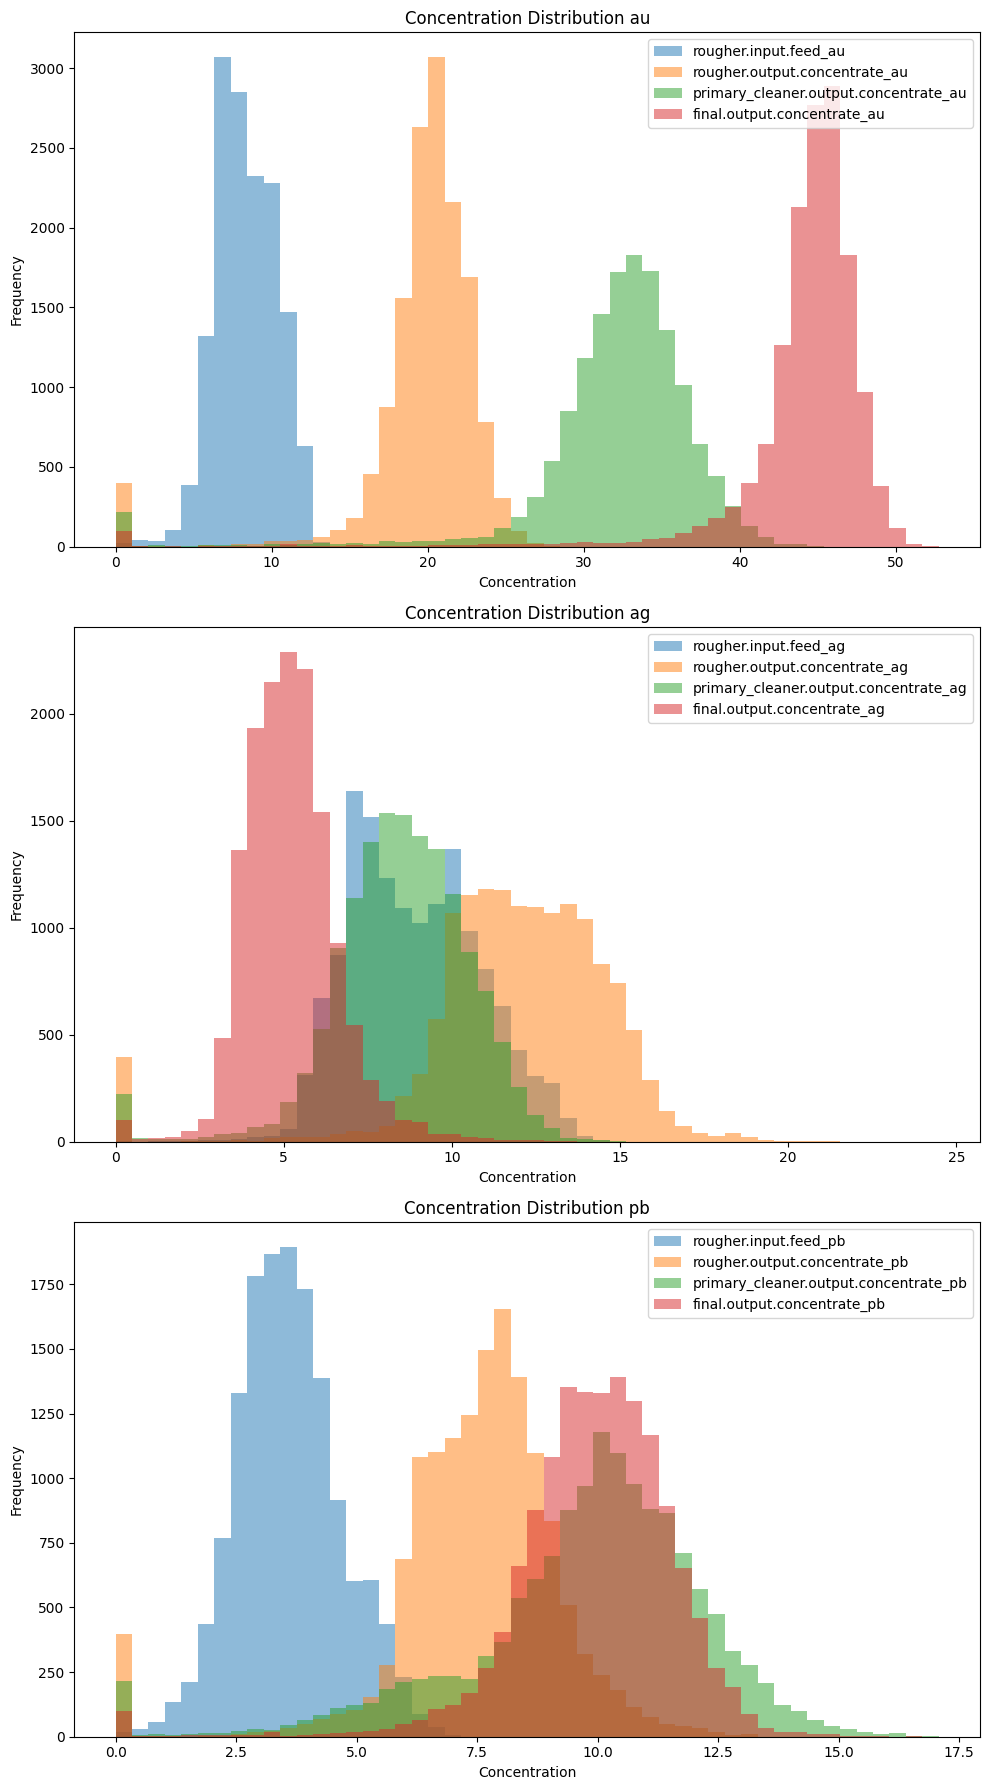

In [15]:
selected_columns = ['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb',
                    'rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb',
                    'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb',
                    'final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb']

subset = gold_train[selected_columns]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 18))

for i, metal in enumerate(["au", "ag", "pb"]):
    metal_columns = [col for col in subset.columns if metal in col]
    subset[metal_columns].plot(kind="hist", alpha=0.5, bins=50, legend=True, title=f"Concentration Distribution {metal}", ax=axes[i])
    axes[i].set_xlabel("Concentration")
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

Based on the graphs, it is evident that the concentration of gold increases from stage to stage. The concentration of silver and lead increases, but not as significantly. I presume this is related to gold being the target metal in this case.

Now, let's check the distributions of particle sizes in the original feed on the training and test sets.

/Users/daniyardjumaliev/Jupyter/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/daniyardjumaliev/Jupyter/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/daniyardjumaliev/Jupyter/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/daniyardjumaliev/Jupyter/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

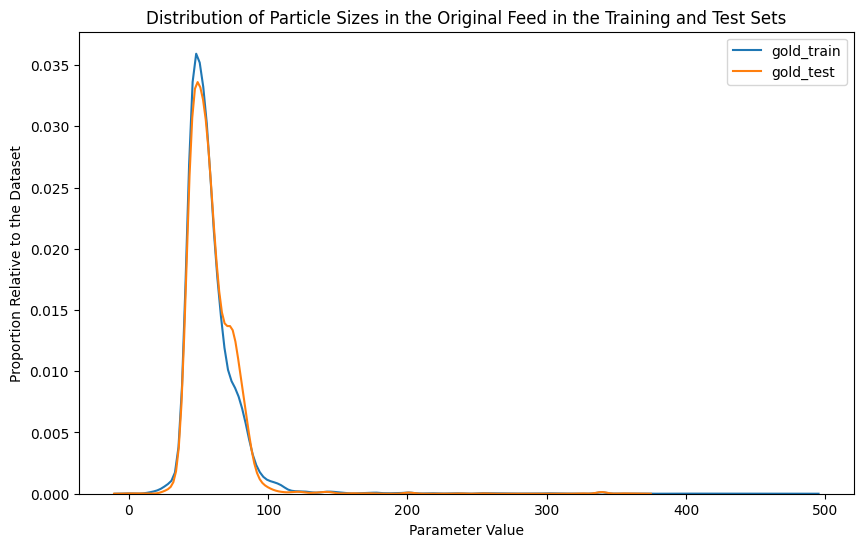

In [16]:
datasets = {'gold_train': gold_train, 'gold_test': gold_test}
selected_column = 'rougher.input.feed_size'

plt.figure(figsize=(10, 6))
for dataset_name, dataset in datasets.items():
    sns.kdeplot(dataset[selected_column], label=dataset_name)

plt.title('Distribution of Particle Sizes in the Original Feed in the Training and Test Sets')
plt.xlabel('Parameter Value')
plt.ylabel('Proportion Relative to the Dataset')
plt.legend()
plt.show()

_Conclusion_: As seen from the graph, the distribution has not changed significantly. The particle size in the training and test sets is either identical or differs insignificantly.

Let's check the distribution of the concentration of all metals.

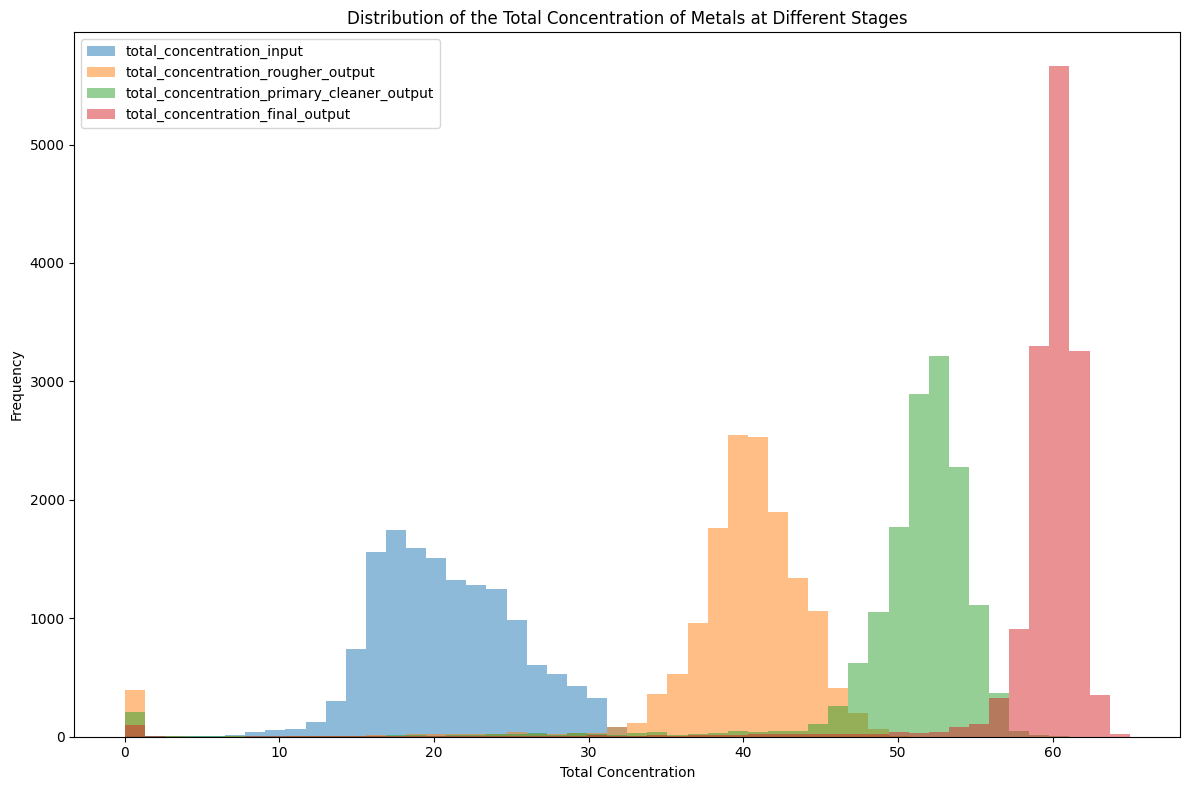

In [17]:
gold_train['total_concentration_input'] = gold_train['rougher.input.feed_au'] + gold_train['rougher.input.feed_ag'] + gold_train['rougher.input.feed_pb']
gold_train['total_concentration_rougher_output'] = gold_train['rougher.output.concentrate_au'] + gold_train['rougher.output.concentrate_ag'] + gold_train['rougher.output.concentrate_pb']
gold_train['total_concentration_primary_cleaner_output'] = gold_train['primary_cleaner.output.concentrate_au'] + gold_train['primary_cleaner.output.concentrate_ag'] + gold_train['primary_cleaner.output.concentrate_pb']
gold_train['total_concentration_final_output'] = gold_train['final.output.concentrate_au'] + gold_train['final.output.concentrate_ag'] + gold_train['final.output.concentrate_pb']

total_concentration_columns = ['total_concentration_input', 'total_concentration_rougher_output', 'total_concentration_primary_cleaner_output', 'total_concentration_final_output']

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

gold_train[total_concentration_columns].plot(kind="hist", alpha=0.5, bins=50, legend=True, title="Distribution of the Total Concentration of Metals at Different Stages", ax=axes)
axes.set_xlabel("Total Concentration")
axes.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

The graph shows anomalies. Let's remove them. To do this, we'll set a minimum threshold of 10 and discard all values below it.

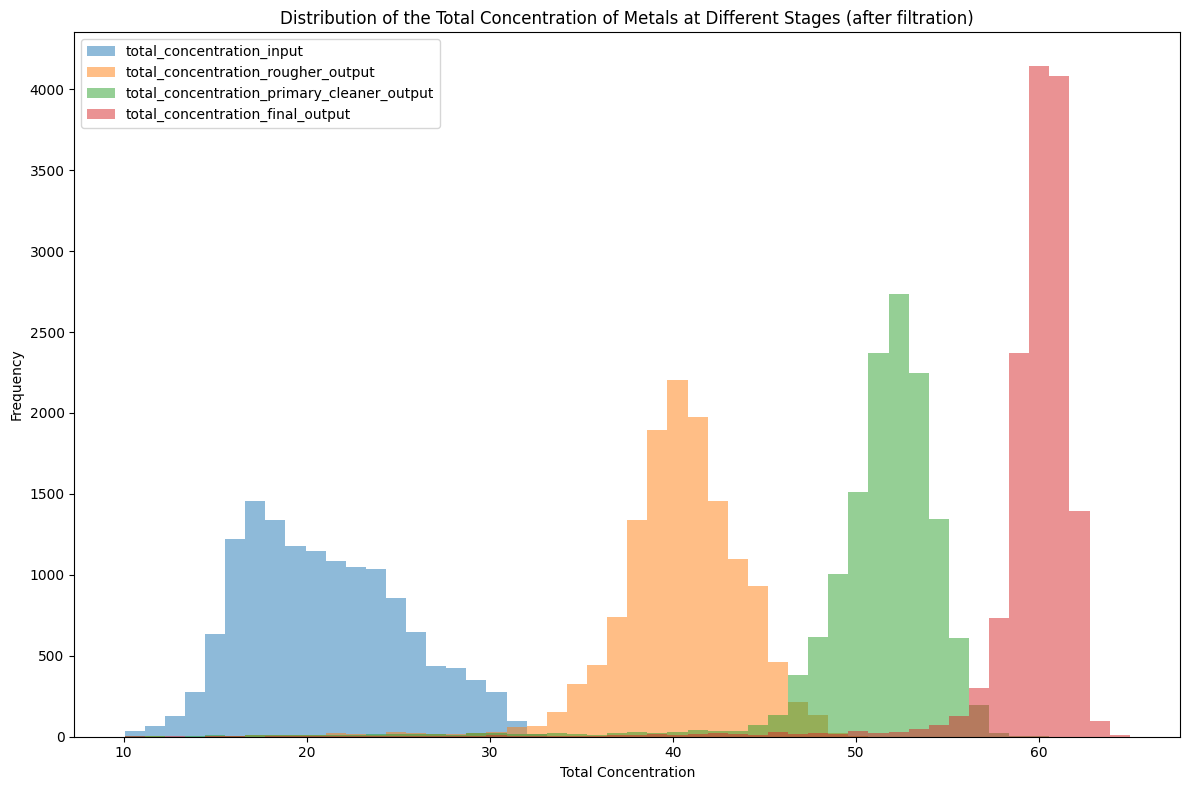

In [18]:
min_threshold = 10  
max_threshold = 100  

gold_train = gold_train[
    (gold_train['total_concentration_input'] >= min_threshold) &
    (gold_train['total_concentration_input'] <= max_threshold) &
    (gold_train['total_concentration_rougher_output'] >= min_threshold) &
    (gold_train['total_concentration_rougher_output'] <= max_threshold) &
    (gold_train['total_concentration_primary_cleaner_output'] >= min_threshold) &
    (gold_train['total_concentration_primary_cleaner_output'] <= max_threshold) &
    (gold_train['total_concentration_final_output'] >= min_threshold) &
    (gold_train['total_concentration_final_output'] <= max_threshold)
]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
gold_train[total_concentration_columns].plot(kind="hist", alpha=0.5, bins=50, legend=True, title="Distribution of the Total Concentration of Metals at Different Stages (after filtration)", ax=axes)
axes.set_xlabel("Total Concentration")
axes.set_ylabel("Frequency")
plt.tight_layout()
plt.show()

_Conclusion_: The distribution of metal concentration in the raw material from stage to stage indicates that, from being relatively smooth at the beginning, the distribution becomes narrower towards the end of the technological process. This suggests that the concentration of metals increases at each stage. Each stage gradually raises the concentration of metals in the raw material. Furthermore, all values below 10 were discarded, as these values can be considered anomalies since there should be some metal content in the ore.

## Model

![Метрика sMAPE](https://pictures.s3.yandex.net/resources/smape_1576238825.jpg)

sMAPE (Symmetric Mean Absolute Percentage Error) is similar to MAE but is expressed not in absolute values but in relative ones. Why is it symmetric? It equally considers the scale of both the target feature and the predictions.

The final sMAPE is calculated using the following formula:

![Метрика итоговая sMAPE](https://pictures.s3.yandex.net/resources/_smape_1576238814.jpg)

Let's write a function to calculate the final sMAPE.

In [19]:
def sMAPE(target, predicted):
    if len(target) != len(predicted):
        return np.nan
    
    n = len(target)
    smape_sum = 0.0
    
    for i in range(n):
        target_value = target[i]
        predicted_value = predicted[i]

        denominator = (abs(target_value) + abs(predicted_value)) / 2 if (target_value + predicted_value) != 0 else 1
        
        smape_sum += (abs(target_value - predicted_value) / denominator)
    
    smape = (100 / n) * smape_sum
    return smape

In [20]:
def total_sMAPE(rougher_target, rougher_predicted, final_target, final_predicted):
    weight_rougher = 0.25
    weight_final = 0.75
    
    sMAPE_rougher = sMAPE(rougher_target, rougher_predicted)
    sMAPE_final = sMAPE(final_target, final_predicted)
    
    total_smape = weight_rougher * sMAPE_rougher + weight_final * sMAPE_final
    
    return total_smape

Let's prepare the data for cross-validation of linear regression and random forest models, ensuring that the column names match those of the test set for subsequent validation. We will remove all columns from the training set similar to the test set. Additionally, we will assess the models using cross-validation. To achieve this, we will create an sMAPE scorer in cross_val_score.

In [21]:
feature_train = gold_train[gold_test.columns.intersection(gold_train.columns)]
feature_train = feature_train.drop('date', axis=1)
target_train_rougher = gold_train['rougher.output.recovery'].to_numpy()
target_train_final = gold_train['final.output.recovery'].to_numpy()

smape_scorer = make_scorer(sMAPE, greater_is_better=False)

display(f'Train features: {feature_train.shape}')
display(f'Target feature(rougher): {target_train_rougher.shape}')
display(f'Target feature(final): {target_train_final.shape}')

'Train features: (13767, 52)'

'Target feature(rougher): (13767,)'

'Target feature(final): (13767,)'

Let's tune the hyperparameters of the random forest using the GridSearchCV method.

In [22]:
param_grid = {
    'max_depth': [1, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_forest = RandomForestRegressor(random_state=12345)

grid_search_rougher = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5, scoring=smape_scorer)
grid_search_rougher.fit(feature_train, target_train_rougher)

grid_search_final = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5, scoring=smape_scorer)
grid_search_final.fit(feature_train, target_train_final)

best_params_rougher = grid_search_rougher.best_params_
best_smape_rougher = -grid_search_rougher.best_score_

best_params_final = grid_search_final.best_params_
best_smape_final = -grid_search_final.best_score_

display(f'Best hyperparameters for rougher: {best_params_rougher}')
display(f'Mean sMAPE for rougher with the best hyperparameters: {best_smape_rougher}')

display(f'Best hyperparameters for final: {best_params_final}')
display(f'Mean sMAPE for final with the best hyperparameters: {best_smape_final}')

"Best hyperparameters for rougher: {'max_depth': 5, 'min_samples_leaf': 1}"

'Mean sMAPE for rougher with the best hyperparameters: 6.2116994764553395'

"Best hyperparameters for final: {'max_depth': 1, 'min_samples_leaf': 1}"

'Mean sMAPE for final with the best hyperparameters: 8.856802828562468'

By grid search, we obtained the following best hyperparameters for the random forest:

- (rougher): 'max_depth=5, min_samples_leaf=1
- (final): 'max_depth=1, min_samples_leaf=1.

Now, through cross-validation, we will select the model with the lowest sMAPE.

In [23]:
linear_regression = LinearRegression()
random_forest_rougher = RandomForestRegressor(random_state=12345, max_depth=5, min_samples_leaf=1)
random_forest_final = RandomForestRegressor(random_state=12345, max_depth=1, min_samples_leaf=1)

scores_lr = cross_val_score(linear_regression, feature_train, target_train_rougher, cv=5, scoring=smape_scorer)
scores_rf = cross_val_score(random_forest_rougher, feature_train, target_train_rougher, cv=5, scoring=smape_scorer)

display(f'Mean sMAPE for linear regression (rougher): {-np.mean(scores_lr)}')
display(f'Mean sMAPE for random forest (rougher): {-np.mean(scores_rf)}')

scores_lr_final = cross_val_score(linear_regression, feature_train, target_train_final, cv=5, scoring=smape_scorer)
scores_rf_final = cross_val_score(random_forest_final, feature_train, target_train_final, cv=5, scoring=smape_scorer)

display(f'Mean sMAPE for linear regression (final): {-np.mean(scores_lr_final)}')
display(f'Mean sMAPE for random forest (final): {-np.mean(scores_rf_final)}')

'Mean sMAPE for linear regression (rougher): 7.128620250060768'

'Mean sMAPE for random forest (rougher): 6.2116994764553395'

'Mean sMAPE for linear regression (final): 9.549748091129839'

'Mean sMAPE for random forest (final): 8.856802828562468'

The random forest model showed the lowest sMAPE value.

Let's test the random forest model on the test set, but for this, we need to extract the target features. We can extract them from the original dataset based on the 'date' feature.

In [24]:
gold_test_targets = gold_test.merge(gold_full[['date', 'rougher.output.recovery', 'final.output.recovery']], on='date', how='inner')

feature_test = gold_test.drop('date', axis=1)
target_test_rougher = gold_test_targets['rougher.output.recovery'].to_numpy() 
target_test_final = gold_test_targets['final.output.recovery'].to_numpy()

display(f'Train features: {feature_test.shape}')
display(f'Target feature(rougher): {target_test_rougher.shape}')
display(f'Target feature(final): {target_test_final.shape}')

'Train features: (4860, 52)'

'Target feature(rougher): (4860,)'

'Target feature(final): (4860,)'

Let's train the random forest model since, after cross-validation, the model does not retain training data. Then, we'll calculate the final sMAPE.

In [25]:
random_forest_rougher = RandomForestRegressor(random_state=12345, max_depth=5, min_samples_leaf=1)
random_forest_final = RandomForestRegressor(random_state=12345, max_depth=1, min_samples_leaf=1)

random_forest_rougher.fit(feature_train, target_train_rougher)
random_forest_final.fit(feature_train, target_train_final)

predicted_rougher = random_forest_rougher.predict(feature_test)
predicted_final = random_forest_final.predict(feature_test)

total_smape = total_sMAPE(target_test_rougher, predicted_rougher, target_test_final, predicted_final)

display(f'Final sMAPE: {total_smape:0.2f}')

'Final sMAPE: 7.56'

Now, let's assess the relevance of our random forest model. To do this, we'll compare it with a constant model using the DummyRegressor algorithm.

In [26]:
dummy_regressor = DummyRegressor(strategy='median')

dummy_regressor.fit(feature_train, target_train_rougher)

dummy_predictions_rougher = dummy_regressor.predict(feature_test)
dummy_predictions_final = dummy_regressor.predict(feature_test)

smape_model_rougher = sMAPE(target_test_rougher, predicted_rougher)
smape_dummy_rougher = sMAPE(target_test_rougher, dummy_predictions_rougher)

smape_model_final = sMAPE(target_test_final, predicted_final)
smape_dummy_final = sMAPE(target_test_final, dummy_predictions_final)

display(f'sMAPE for our model (rougher): {smape_model_rougher}')
display(f'sMAPE for the dummy model (rougher): {smape_dummy_rougher}')

display(f'sMAPE for our model (final): {smape_model_final}')
display(f'sMAPE for the dummy model (final): {smape_dummy_final}')

'sMAPE for our model (rougher): 3.776486369357665'

'sMAPE for the dummy model (rougher): 5.833112278531343'

'sMAPE for our model (final): 8.825097411422128'

'sMAPE for the dummy model (final): 24.695670755651193'

Our random forest model has a better sMAPE metric than the constant model; therefore, it is relevant.

__Overall conclusion__:

- During data loading, it was observed that the test table lacked target features; it only had features for prediction. Therefore, it was decided to extract target features from the original table based on the 'date' feature.

- All tables had missing values. Since the condition specified that data is usually indexed by the date and time of information retrieval (the 'date' feature), and neighboring parameters over time are often similar, missing values were filled using linear interpolation.

- It was noted that there was no strong correlation between the target features and the training features, except for rougher.output.concentrate and rougher.output.recovery. The number of zero values in the target columns was not critical.

- After calculating MAE, it was found that MAE was approximately 9.83758577644259e-15, indicating that the absolute mean deviation between manually calculated values and actual recovery values was very close to zero. This suggests high precision in recovery calculations, aligning well with expected results.

- During data analysis, it was observed that the concentration of gold increased from stage to stage. The concentration of silver and lead increased, but not as significantly. The total concentration of metals in the raw material from stage to stage showed a narrower distribution towards the end of the technological process, indicating an increase in metal concentration at each stage. This likely indicates a correct technological process. Summarized values less than 10 were discarded as anomalies.

- A function was written to calculate sMAPE (Symmetric Mean Absolute Percentage Error).

- When selecting the optimal model for predicting the efficiency of enrichment, both for rougher and final concentrate, the main metric was sMAPE. The random forest model with default values of 100 decision trees, a depth of 5 (for rougher concentrate) and 1 (for final concentrate), and a minimum number of samples in a leaf equal to 1 for both types of concentrate, showed the lowest sMAPE on the validation set: 6.21% for rougher concentrate and 8.86% for final concentrate. __Further, this model showed a final sMAPE of 7.56%. The random forest model was also checked for relevance by comparing it with the DummyRegressor algorithm with a median strategy. The random forest model can predict process results with a relatively small error and is therefore recommended for use.__